In [1]:
from py2neo import Graph
import matplotlib.pyplot as plt
from tabulate import tabulate

In [2]:
graph = Graph(
    "bolt://localhost:7687",
    auth=("neo4j", "admin"),
    # name="neo4j-2",
)

In [10]:
def plot_distribution(data):
    plt.bar(data.keys(), data.values())

def plot_ratings_distribution():
    results = graph.run("""
        match (u:User)-[r:RATES]-(m:Movie)
        return r.rating as rating, count(r) as count order by r.rating
    """).data()
    ratings_dict = { rat["rating"]: rat["count"] for rat in results }
    plot_distribution(ratings_dict)

def plot_ratings_per_user_distribution():
    results = graph.run("""
        MATCH (u:User)-[r:RATES]-(m)
        with u, count(r) as counter
        return u.username as username, counter order by counter desc;
    """).data()
    ratings_dict = { rat["username"]: rat["counter"] for rat in results }
    plot_distribution(ratings_dict)

def plot_ratings_per_movie_distribution():
    results = graph.run("""
        MATCH (u:User)-[r:RATES]-(m)
        WITH m, count(r) as counter
        RETURN m.id as id, counter order by counter desc;
    """).data()
    ratings_dict = { rat["id"]: rat["counter"] for rat in results }
    plot_distribution(ratings_dict)

def count_graph():
    movies = graph.run("match (m:Movie) return count(m)").evaluate()
    users = graph.run("match (u:User) return count(u)").evaluate()
    ratings = graph.run("match (u:User)-[r:RATES]-(m:Movie) return count(r)").evaluate()
    average_ratings_per_user = graph.run("""
        MATCH (u:User)
        WITH u, size((u)-[:RATES]-()) as rateCount
        RETURN avg(rateCount) as averageRateCount
    """).evaluate()
    average_ratings_per_movie = graph.run("""
        MATCH (m:Movie)
        WITH m, size((m)-[:RATES]-()) as rateCount
        RETURN avg(rateCount) as averageRateCount
    """).evaluate()
    print(tabulate([[
        movies,
        users,
        ratings,
        average_ratings_per_movie,
        average_ratings_per_user
    ]], headers=["Movies", "Users", "Ratings", "Average ratings per movie", "Average ratings per user"]))

def get_graph_statistics():
    plot_ratings_distribution()
    count_graph()

def delete_random_ratings(rating: int, lim=100):
    graph.run(f"""
        match (u:User)-[r:RATES {{ rating: {rating} }}]-(m:Movie)
        with r, rand() as rand order by rand limit {lim}
        detach delete r;
    """)

def delete_unrated_movies():
    graph.run("""
    match (m:Movie) where not (:User)-[:RATES]-(m) detach delete (m);
    """)

def delete_unconnected_nodes():
    graph.run("""
    match (m) where not ()-[]-(m) detach delete (m);
    """)

def delete_random_users(lim=100):
    graph.run(f"""
        match (u:User)
        with u, rand() as rand
        order by rand limit {lim}
        detach delete u
    """)

def delete_random_movies(lim=100):
    graph.run(f"""
        match (m:Movie)
        with m, rand() as rand
        order by rand limit {lim}
        detach delete m
    """)

def sync_graph():
    for _ in range(2):
        delete_unconnected_nodes()
    get_graph_statistics()

### Starting from the 550K ratings version of the graph 

  Movies    Users    Ratings    Average ratings per movie    Average ratings per user
--------  -------  ---------  ---------------------------  --------------------------
    3705     9333     565154                      152.538                     60.5544


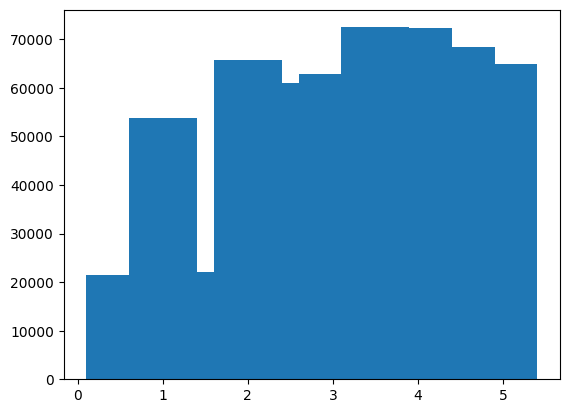

In [4]:
get_graph_statistics()

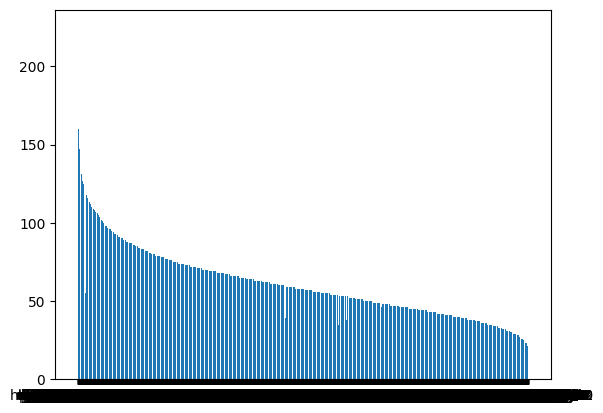

In [5]:
plot_ratings_per_user_distribution()

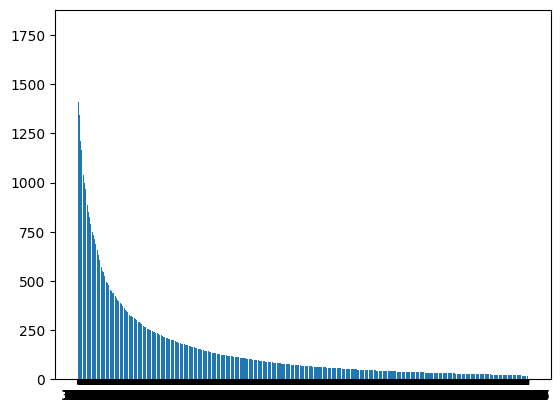

In [6]:
plot_ratings_per_movie_distribution()

### Applying multiple steps to reduce its size

  Movies    Users    Ratings    Average ratings per movie    Average ratings per user
--------  -------  ---------  ---------------------------  --------------------------
    3705     9133     553317                      149.343                     60.5844


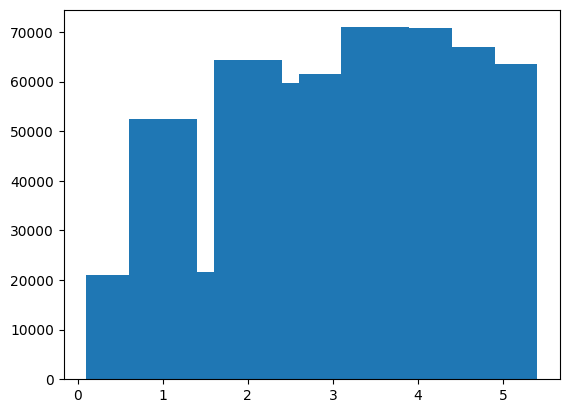

In [9]:
delete_random_users(200)
sync_graph()

  Movies    Users    Ratings    Average ratings per movie    Average ratings per user
--------  -------  ---------  ---------------------------  --------------------------
    3505     9133     522479                      149.067                     57.2078


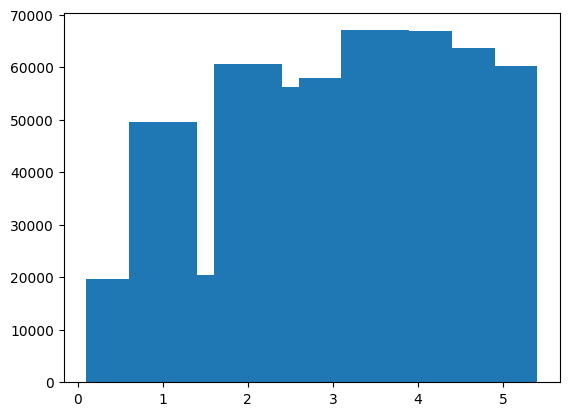

In [11]:
delete_random_movies(200)
sync_graph()

  Movies    Users    Ratings    Average ratings per movie    Average ratings per user
--------  -------  ---------  ---------------------------  --------------------------
    3505     8633     494047                      140.955                     57.2277


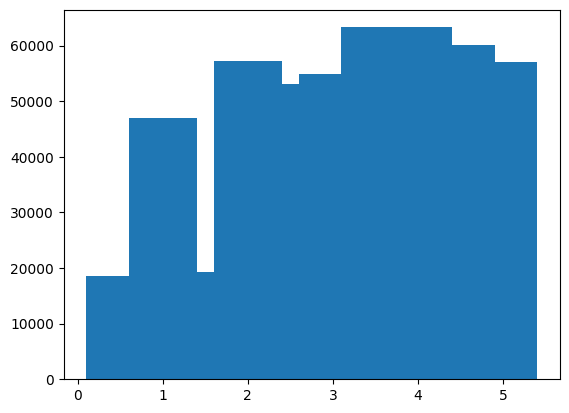

In [12]:
delete_random_users(500)
sync_graph()

  Movies    Users    Ratings    Average ratings per movie    Average ratings per user
--------  -------  ---------  ---------------------------  --------------------------
    3505     8133     464952                      132.654                     57.1686


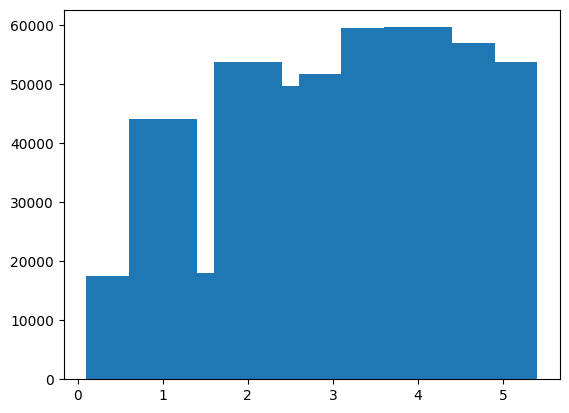

In [13]:
delete_random_users(500)
sync_graph()

  Movies    Users    Ratings    Average ratings per movie    Average ratings per user
--------  -------  ---------  ---------------------------  --------------------------
    3505     7133     407775                      116.341                     57.1674


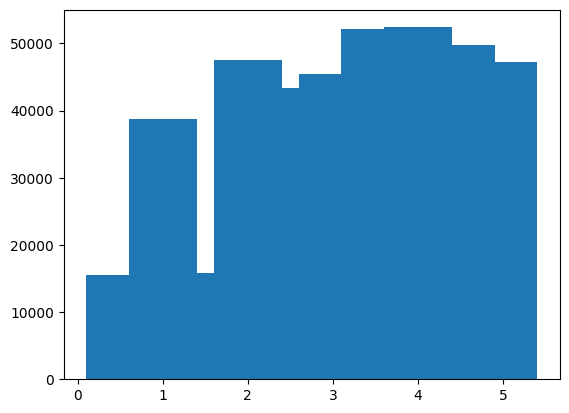

In [14]:
delete_random_users(1000)
sync_graph()

  Movies    Users    Ratings    Average ratings per movie    Average ratings per user
--------  -------  ---------  ---------------------------  --------------------------
    3505     6633     378762                      108.063                     57.1027


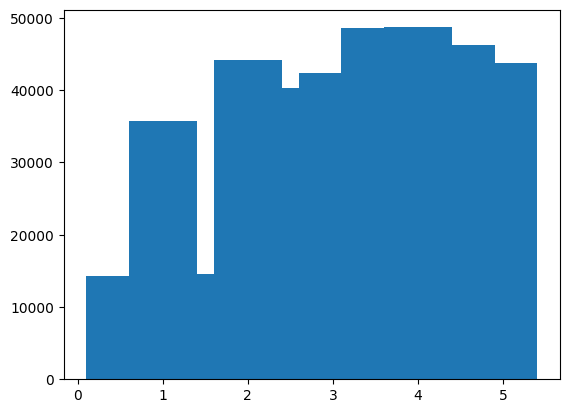

In [15]:
delete_random_users(500)
sync_graph()

  Movies    Users    Ratings    Average ratings per movie    Average ratings per user
--------  -------  ---------  ---------------------------  --------------------------
    3505     5633     322107                      91.8993                     57.1821


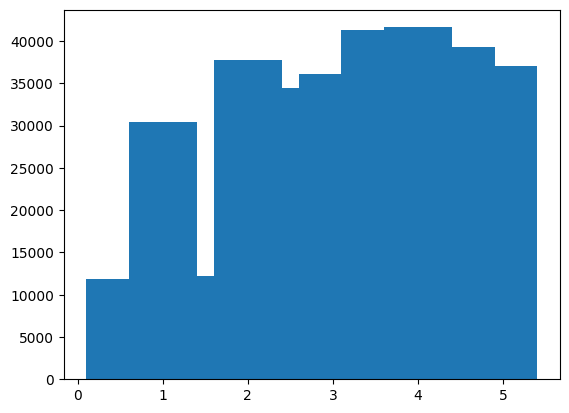

In [16]:
delete_random_users(1000)
sync_graph()

  Movies    Users    Ratings    Average ratings per movie    Average ratings per user
--------  -------  ---------  ---------------------------  --------------------------
    3505     4633     263818                       75.269                     56.9432


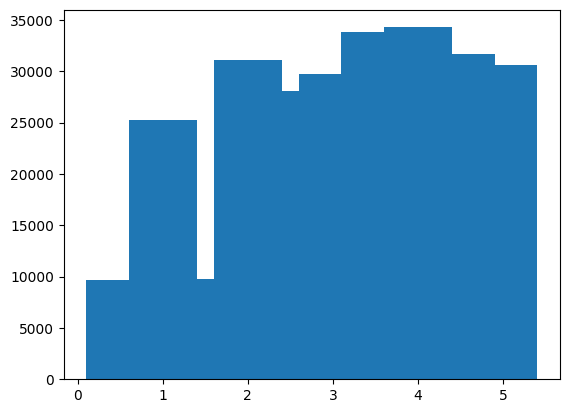

In [17]:
delete_random_users(1000)
sync_graph()

  Movies    Users    Ratings    Average ratings per movie    Average ratings per user
--------  -------  ---------  ---------------------------  --------------------------
    3205     4633     242476                      75.6555                     52.3367


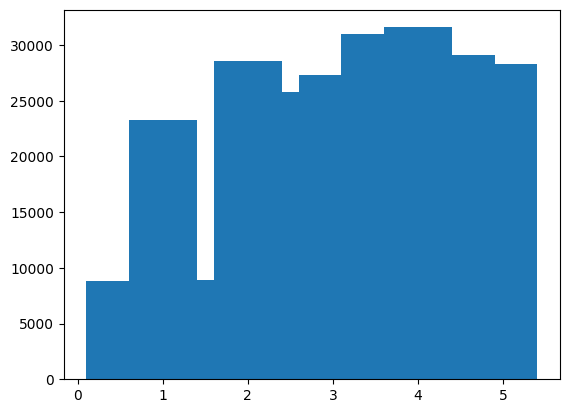

In [18]:
delete_random_movies(300)
sync_graph()

  Movies    Users    Ratings    Average ratings per movie    Average ratings per user
--------  -------  ---------  ---------------------------  --------------------------
    2705     4633     204277                      75.5183                     44.0917


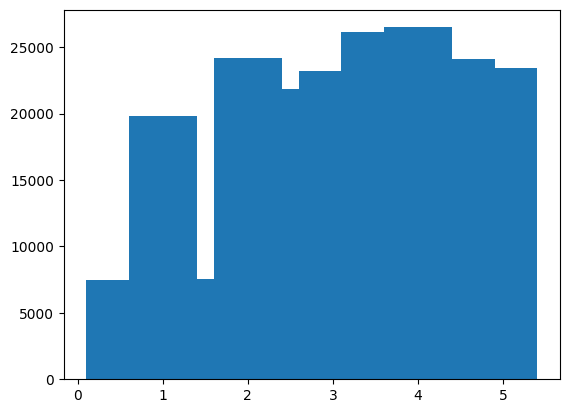

In [19]:
delete_random_movies(500)
sync_graph()

  Movies    Users    Ratings    Average ratings per movie    Average ratings per user
--------  -------  ---------  ---------------------------  --------------------------
    2205     4633     166315                      75.4263                     35.8979


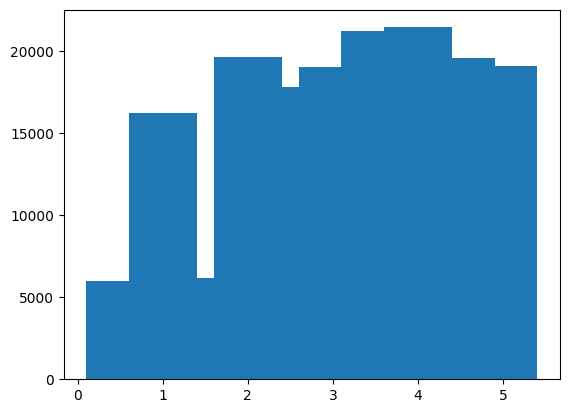

In [20]:
delete_random_movies(500)
sync_graph()

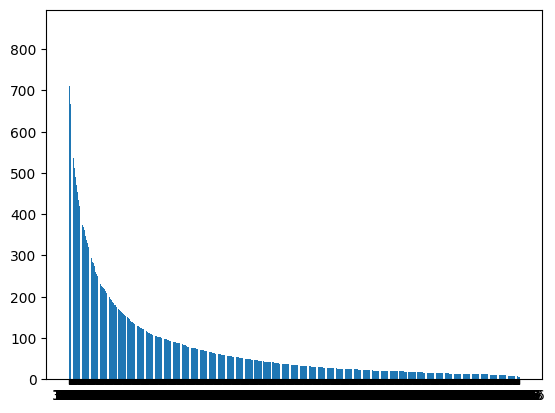

In [21]:
plot_ratings_per_movie_distribution()

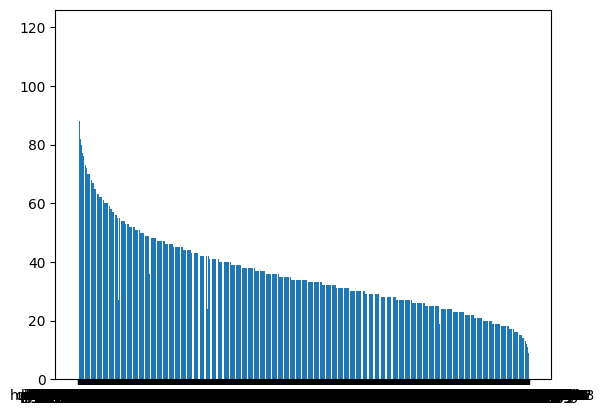

In [22]:
plot_ratings_per_user_distribution()

In [24]:
# delete movie with little ratings
graph.run("""
    match (m:Movie)-[r:RATES]-(u:User)
    with m, count(r) as counter
    where counter<12
    detach delete m
""")

(No data)

In [30]:
delete_unconnected_nodes()

### Final state of the graph

  Movies    Users    Ratings    Average ratings per movie    Average ratings per user
--------  -------  ---------  ---------------------------  --------------------------
    2055     4633     164877                      80.2321                     35.5875


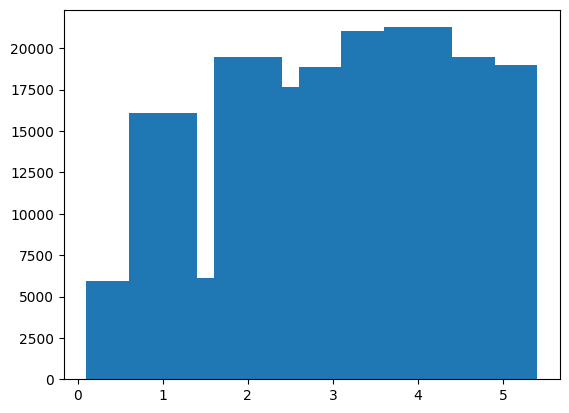

In [31]:
get_graph_statistics()

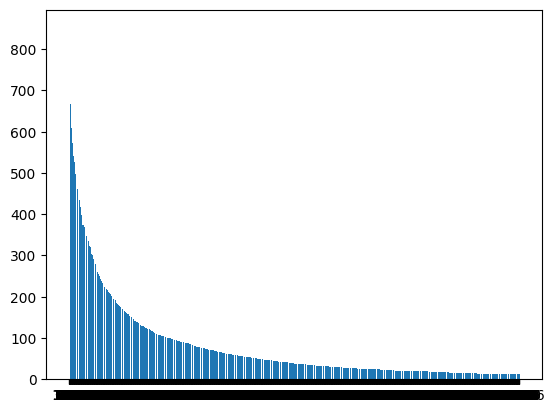

In [32]:
plot_ratings_per_movie_distribution()

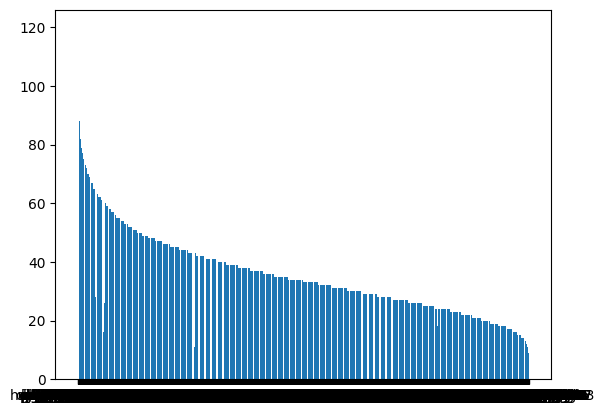

In [33]:
plot_ratings_per_user_distribution()